In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import mlflow


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam

from sklearn.metrics import root_mean_squared_error as rmse
import joblib

2024-12-11 23:11:45.405654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 23:11:45.406720: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 23:11:45.409909: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 23:11:45.418591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733976705.432239   43245 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733976705.43

In [3]:
# Set graphs style
sns.set_style('whitegrid')
#plt.style.use("fivethirtyeight")
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [4]:
# Load the data

path = '../data/raw/Timeseries_11.573_-72.814_E5_3kWp_crystSi_16_v45deg_2005_2023.csv'

# Lines to ignore
n = 10
m = 13

# Read the file
with open(path, 'r') as file:
    lines = file.readlines()

# Remove first nth and last mth lines
csvLines = lines[n:-m]

# Join the lines and load the to pandas
csvData = StringIO("".join(csvLines))
rawData = pd.read_csv(csvData,index_col='time')

rawData

P   Gb(i)   Gd(i)  Gr(i)  H_sun    T2m  WS10m  Int
time                                                                   
20050101:0030     0.00    0.00    0.00   0.00   0.00  25.87   3.86  0.0
20050101:0130     0.00    0.00    0.00   0.00   0.00  25.28   3.72  0.0
20050101:0230     0.00    0.00    0.00   0.00   0.00  24.88   3.72  0.0
20050101:0330     0.00    0.00    0.00   0.00   0.00  24.56   3.66  0.0
20050101:0430     0.00    0.00    0.00   0.00   0.00  24.45   3.45  0.0
...                ...     ...     ...    ...    ...    ...    ...  ...
20231231:1930  1912.60  473.70  171.50  13.06  38.45  30.61   4.62  0.0
20231231:2030  1564.37  388.15  134.76   8.55  26.82  30.14   5.31  0.0
20231231:2130  1303.80  351.40   84.11   4.42  14.16  29.41   5.66  0.0
20231231:2230    86.74    0.00   42.63   1.47   0.91  28.66   5.45  0.0
20231231:2330     0.00    0.00    0.00   0.00   0.00  27.76   5.17  0.0

[166536 rows x 8 columns]

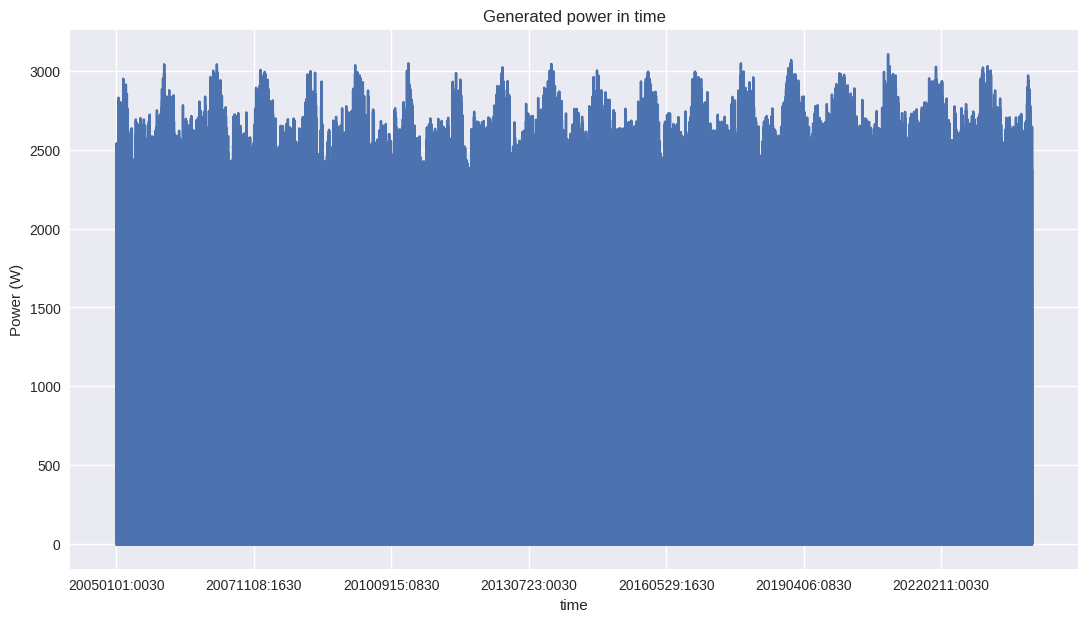

In [5]:
# Visualize 

fig = plt.figure(figsize=(13,7))

rawData['P'].plot()
plt.ylabel('Power (W)')
plt.title('Generated power in time')
plt.show()

In [6]:
print(f"Tracking Server URI: '{mlflow.get_tracking_uri()}'")

Tracking Server URI: 'file:///home/sebastian/Desktop/For_studyng/TalentoTech/FinalProject/Talento_tech_final/ExploratoryModelGenerate/mlruns'


Start the Neural network tracking


The implementation of this neural network is to study how when given some climatological condition can alter the power generation.

The training is the generated power by 10 solar panels placed on la Guajira durin the period from 2005 to 2023.

The idea, is to stimate the amount of power the same panel array can generate under other different conditions in different locations iside Colombia.

In [7]:
from tensorflow.keras.optimizers import RMSprop

In [8]:
# Function to track experiment fro dense NN

def NNExperiment(data, testDataPercentage:float, epochs:int, lr:float,run_name:str):

    # Separate the data
    X = data[['Gd(i)','Gb(i)','Gr(i)','T2m','WS10m']]
    Y = data[['P']]
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Separate train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y, test_size=testDataPercentage,random_state=40) 
   
    
    # Create the structure
    model = Sequential([
        Input(shape=(5,)),  # Input layer, for 3 characteristics
        Dense(128, activation='relu'),  
        Dense(64, activation='relu'),   
        Dense(10, activation='softmax'),
        Dense(1)                # One neuron for regression
        
    ])

    # Compile NN
    model.compile(optimizer = RMSprop(learning_rate=lr), loss='mean_squared_error', metrics=['mean_squared_error'])
    
    # Train NN
    history = model.fit(X_train, y_train,epochs=epochs, validation_split=0.2)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate RMSE
    rmseValue = rmse(y_true=y_test, y_pred=predictions)
    
    # Results dataframe
    # Ensure predictions and y_test are compatible
    data2 = np.column_stack((predictions, y_test))  # Combine columns
    result = pd.DataFrame(data2, columns=['pred', 'real'])
    
    # Start run
    with mlflow.start_run(run_name= run_name): 
        
        mlflow.log_param('run name',run_name )
        
        mlflow.log_param('Test percentage', testDataPercentage)
        mlflow.log_param('epohcs', epochs)
        mlflow.log_param('Learning rate', lr)
        mlflow.log_param('Optimizer', RMSprop ),
        mlflow.log_param('metric', 'Mean squared error' )
        mlflow.log_metric('rmse', rmseValue)
        
        mlflow.sklearn.log_model(model, artifact_path='model')
        
    # guardamos el modelo y el scaler para futuras predicciones
    joblib.dump(scaler,'../models/NN_scaler.pkl')
    joblib.dump(model,'../models/NNModel')
    
    # Guardamos las predicciones
    result.to_csv('../data/processed/NN_pred.csv', index=False)
    
    testeo = np.array([0,0,0,0,0]).reshape(1,-1)
    testeoscalado = scaler.transform(testeo)
    testeo2 = model.predict(testeoscalado)
    
    return result,rmseValue, history, model, testeo2

In [9]:
# Set the experiment
experiment_name = "Dense_NN_Experiment"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///home/sebastian/Desktop/For_studyng/TalentoTech/FinalProject/Talento_tech_final/ModelGenerate/mlruns/270526666736579697', creation_time=1733169568396, experiment_id='270526666736579697', last_update_time=1733169568396, lifecycle_stage='active', name='Dense_NN_Experiment', tags={}>

In [10]:
# Runs for the experiment

result = NNExperiment(data=rawData,testDataPercentage=0.2,epochs=80,lr=0.01,run_name='Run_9')
result[0]

Epoch 1/80


2024-12-11 23:11:54.302800: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


3331/3331 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1730482.1250 - mean_squared_error: 1730482.1250 - val_loss: 1652871.2500 - val_mean_squared_error: 1652871.2500
Epoch 2/80
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1621362.2500 - mean_squared_error: 1621362.2500 - val_loss: 1546538.8750 - val_mean_squared_error: 1546538.8750
Epoch 3/80
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1504596.0000 - mean_squared_error: 1504596.0000 - val_loss: 1444640.1250 - val_mean_squared_error: 1444640.1250
Epoch 4/80
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1409296.1250 - mean_squared_error: 1409296.1250 - val_loss: 1346847.6250 - val_mean_squared_error: 1346847.6250
Epoch 5/80
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1326283.5000 - mean_squared_error: 1326283.5000 - val_loss: 1253180.5000 - val_mean_squared_error: 1253180.5000
Epoch 6/80
3331/3331 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1233953.7500 - mean_squared_error: 1233953.7500 - val_loss: 1163544.2500 - val_

2024/12/11 23:17:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/home/sebastian/Desktop/For_studyng/TalentoTech/FinalProject/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


pred     real
0       660.163574   653.11
1         0.095947     0.00
2         0.095947     0.00
3         0.095947     0.00
4      1701.427368  1687.26
...            ...      ...
33303  2335.097168  2321.01
33304  2137.723633  2120.08
33305     0.096313     0.00
33306     0.095947     0.00
33307     0.095947     0.00

[33308 rows x 2 columns]

run_8 is not good.

The following lines are for run_7

In [11]:
print(result[-1])

[[4.104492]]


In [12]:
print(f'rmse: {result[1]}')

rmse: 10.957905897975605


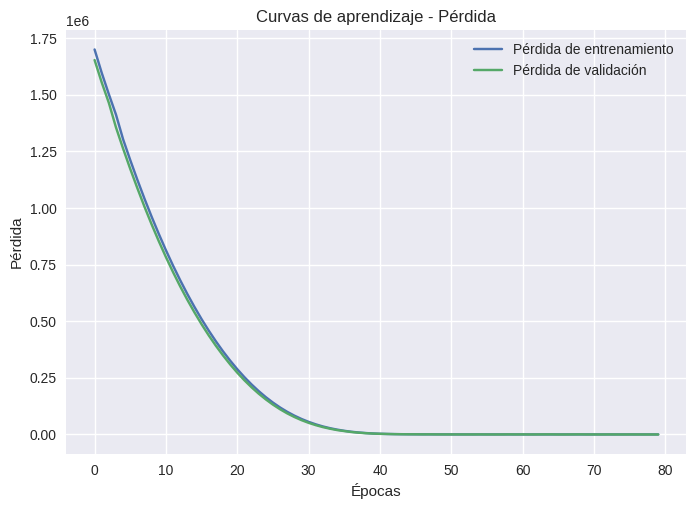

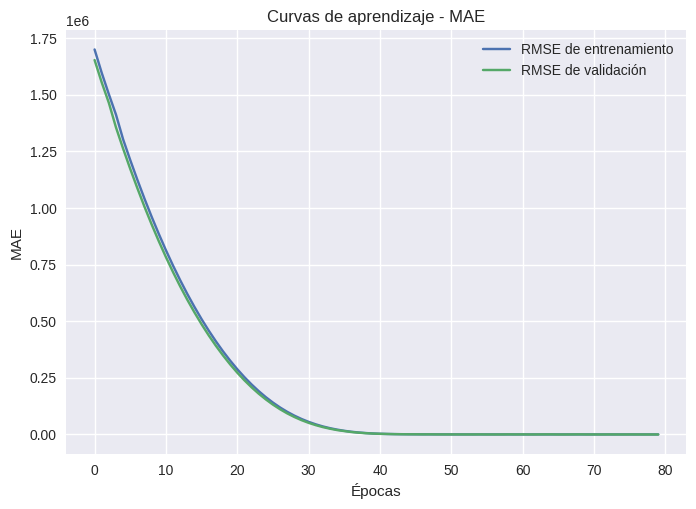

In [ ]:
# Graficar la pérdida
plt.plot(result[2].history['loss'], label='Pérdida de entrenamiento')
plt.plot(result[2].history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curvas de aprendizaje - Pérdida')
plt.show()

# Graficar la métrica adicional (MAE)
plt.plot(result[2].history['mean_squared_error'], label='RMSE de entrenamiento')
plt.plot(result[2].history['val_loss'], label='RMSE de validación')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.title('Curvas de aprendizaje - RMSE')
plt.show()


Lastly, we found that the most stable and correct version is the run_7, we can load and use that model for future predictions.

The model doesnot presents overfitting.

In [ ]:
# Convertir el history en un DataFrame de pandas
history_df = pd.DataFrame(result[2].history)

# Guardar el DataFrame como un archivo CSV
history_df.to_csv('../data/processed/history_DenseNN_run7.csv', index=False)

print("History guardado en history_DenseNN_run7.csv")

History guardado en history_DenseNN_run7.csv
